This notebook presents how to fit log Gaussian tuning curves to the data from the NSDsyn dataset. In this example, the data is first binned by eccentricity (0.5-1, 1-2, & 2-4 deg) and then averaged across stimulus classes. The tuning curves are fitted for each eccentricity bin. 

Related snakemake rules: `binning`, `fit_tuning_curves`

# Configurations

In [1]:
import sys
sys.path.append('..')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sfp_nsdsyn import *
import warnings
import itertools
warnings.filterwarnings("ignore", category=UserWarning)
pd.options.mode.chained_assignment = None
%load_ext autoreload
%autoreload 2

In [2]:
output_dir='/Volumes/server/Projects/sfp_nsd/derivatives'
fig_dir=os.path.join(output_dir, 'figures/sfp_model/results_1D/nsdsyn')
precision_dir='/Volumes/server/Projects/sfp_nsd/derivatives/dataframes/nsdsyn/precision'

In [3]:
stim_classes=['annulus', 'pinwheel', 'forward spiral', 'reverse spiral']
e1, e2=0.5, 4
enum='log3'
lr = 0.005
max_epoch = 10000
subj_list = [utils.sub_number_to_string(sn, 'nsdsyn') for sn in np.arange(1,9)]
subj='subj01'
roi='V1'
vs='pRFcenter'

# Load betas and experimental design information

In [4]:
subj_df = pd.read_csv(os.path.join(output_dir, 'dataframes', 'nsdsyn', 'model', f'dset-nsdsyn_sub-{subj}_roi-{roi}_vs-{vs}.csv'))
subj_df = subj_df.query('~names.str.contains("intermediate").values')


# 1. Binning

In [5]:
bin_list, bin_labels = tuning.get_bin_labels(e1, e2, 'log3')
subj_df['ecc_bin'] = tuning.bin_ecc(subj_df['eccentricity'], bin_list, bin_labels)
#bin_df = subj_df.groupby(['sub','vroinames','ecc_bin','freq_lvl','names']).mean().reset_index()
bin_df = tuning.summary_stat_for_ecc_bin(subj_df,
                                       to_group=['sub','vroinames','ecc_bin','freq_lvl','names'],
                                       to_bin=['betas', 'local_sf'],
                                       central_tendency='mean')

In [6]:
bin_df

,sub,vroinames,ecc_bin,freq_lvl,names,betas,local_sf
0,subj01,V1,0.5-1.0 deg,0,annulus,1.386069,1.286699
1,subj01,V1,0.5-1.0 deg,0,forward spiral,1.829799,1.213111
2,subj01,V1,0.5-1.0 deg,0,pinwheel,1.678538,1.286699
3,subj01,V1,0.5-1.0 deg,0,reverse spiral,2.521147,1.213111
4,subj01,V1,0.5-1.0 deg,1,annulus,2.078130,2.358948
...,...,...,...,...,...,...,...
67,subj01,V1,2.0-4.0 deg,4,reverse spiral,2.835035,4.064872
68,subj01,V1,2.0-4.0 deg,5,annulus,2.226701,7.508372
69,subj01,V1,2.0-4.0 deg,5,forward spiral,2.125459,7.549048
70,subj01,V1,2.0-4.0 deg,5,pinwheel,1.856845,7.508372


## Sanity check: Datapoints only

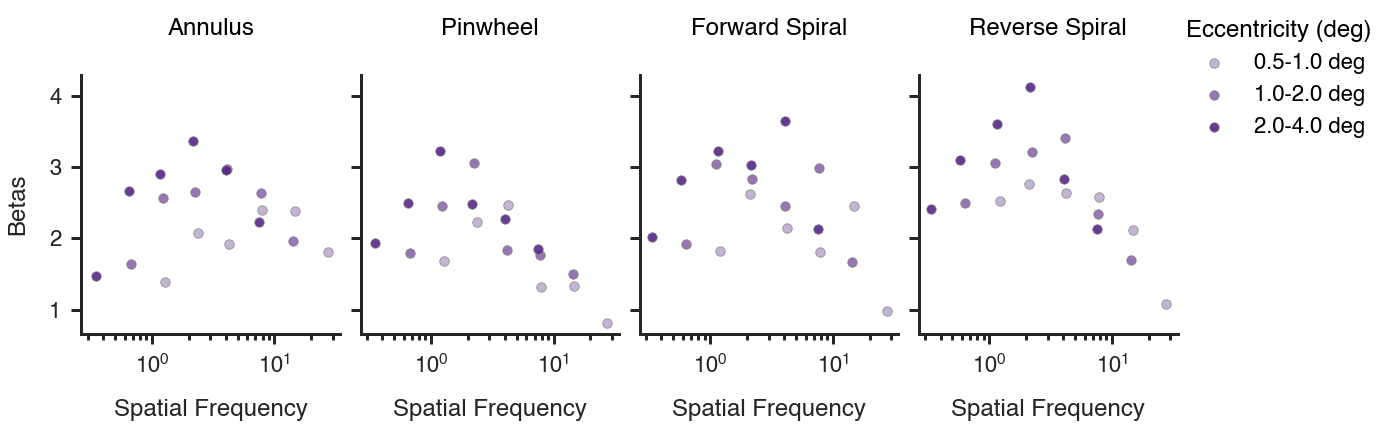

In [7]:
ecc_colors = utils.get_continuous_colors(len(bin_labels)+1, '#3f0377')
ecc_colors = ecc_colors[1:]
vis1D.plot_datapoints(bin_df, 'local_sf', 'betas', hue='ecc_bin', hue_order=bin_labels, 
                      col='names', col_order=stim_classes, 
                    height=6, aspect=0.7, lgd_title='Eccentricity (deg)',
                    palette=ecc_colors)

# 2. Fitting log Gaussian curves for every eccentricity bin

In [8]:
avg_bin_df = bin_df.groupby(['sub','ecc_bin','vroinames','freq_lvl']).mean().reset_index()


In [9]:
loss_history, model_history = pd.DataFrame({}), pd.DataFrame({})
for ecc_bin in avg_bin_df.ecc_bin.unique():
    print(f'{ecc_bin}')
    tmp = avg_bin_df.query('ecc_bin == @ecc_bin')
    my_model = tuning.LogGaussianTuningModel()
    my_dataset = tuning.LogGaussianTuningDataset(tmp['local_sf'], tmp['betas'])
    tmp_loss_history, tmp_model_history = tuning.fit_tuning_curves(my_model, my_dataset, 
                                                                   max_epoch=100, print_every=50, 
                                                                   learning_rate=0.01)
    tmp_model_history['ecc_bin'] = ecc_bin
    tmp_loss_history['ecc_bin'] = ecc_bin
    model_history = pd.concat((model_history, tmp_model_history), axis=0)
    loss_history = pd.concat((loss_history, tmp_loss_history), axis=0)


0.5-1.0 deg
**epoch no.0 loss: 3.88222
**epoch no.49 loss: 2.59849
**epoch no.99 loss: 1.15669
**epoch no.100: Finished! final params {'slope': 2.076, 'mode': 1.692, 'sigma': 1.587}
Elapsed time: 0.07 sec 

1.0-2.0 deg
**epoch no.0 loss: 5.89247
**epoch no.49 loss: 4.49853
**epoch no.99 loss: 2.53081
**epoch no.100: Finished! final params {'slope': 1.18, 'mode': 2.434, 'sigma': 1.775}
Elapsed time: 0.05 sec 

2.0-4.0 deg
**epoch no.0 loss: 6.61654
**epoch no.49 loss: 4.48473
**epoch no.99 loss: 2.4692
**epoch no.100: Finished! final params {'slope': 1.529, 'mode': 1.371, 'sigma': 1.991}
Elapsed time: 0.05 sec 


# 3. Plotting the results

## 3.1. loss and model history checks 

In [8]:
args = ['class', 'lr', 'eph', 'dset', 'sub', 'roi']
l, m = [], []
for stim_type, subj in itertools.product(stim_classes, subj_list):
    stim_type = stim_type.replace(' ', '-')
    loss_file_name = f'loss-history_class-{stim_type}_lr-{lr}_eph-{max_epoch}_binned-ecc-{e1}-{e2}_nbin-{enum}_dset-nsdsyn_sub-{subj}_roi-{roi}_vs-{vs}.h5'
    model_file_name = f'model-history_class-{stim_type}_lr-{lr}_eph-{max_epoch}_binned-ecc-{e1}-{e2}_nbin-{enum}_dset-nsdsyn_sub-{subj}_roi-{roi}_vs-{vs}.h5'
    l.append(os.path.join(output_dir, 'sfp_model', 'results_1D', 'nsdsyn', loss_file_name))
    m.append(os.path.join(output_dir, 'sfp_model', 'results_1D', 'nsdsyn', model_file_name))


In [9]:
loss_df = tuning.load_history_files(l, *args)
model_df = tuning.load_history_files(m, *args)


In [10]:
ecc_colors = utils.get_continuous_colors(len(bin_labels)+1, '#3f0377')
ecc_colors = ecc_colors[1:]

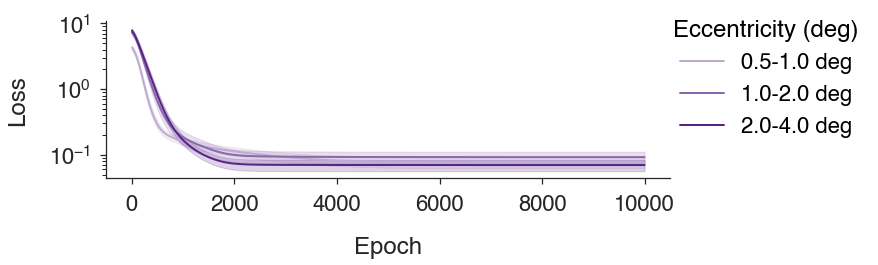

In [15]:
vis.plot_loss_history(loss_df[loss_df['epoch'] % 3 != 0], 
                      hue='ecc_bin', hue_order=bin_labels, 
                      lgd_title='Eccentricity (deg)', 
                      log_y=True, palette=ecc_colors, errorbar='se')

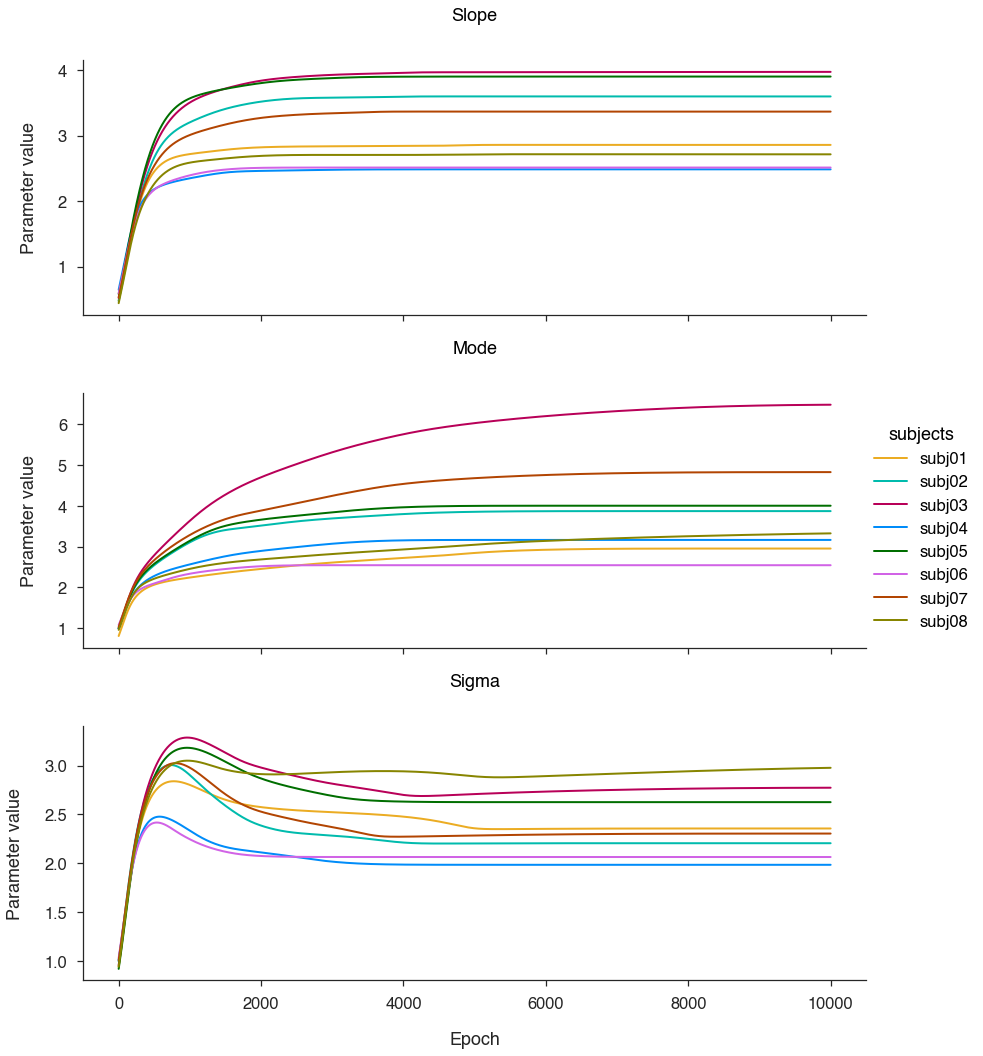

In [86]:
vis.plot_param_history(model_df[loss_df['epoch'] % 2 != 0], 
                       ['slope', 'mode', 'sigma'], [1, 2, 3],  #ecc_bin separately
                       hue='ecc_bin', hue_order=bin_labels, 
                       lgd_title='Eccentricity (deg)', ci=68,
                       palette=ecc_colors)

In [91]:
loss_df

,ecc_bin,epoch,loss,names,lr_rate,max_epoch,dset,sub,vroinames
0,0.5-1.0 deg,0,3.369475,annulus,0.005,10000,nsdsyn,subj01,V1
1,0.5-1.0 deg,1,3.358581,annulus,0.005,10000,nsdsyn,subj01,V1
2,0.5-1.0 deg,2,3.347621,annulus,0.005,10000,nsdsyn,subj01,V1
3,0.5-1.0 deg,3,3.336593,annulus,0.005,10000,nsdsyn,subj01,V1
4,0.5-1.0 deg,4,3.325499,annulus,0.005,10000,nsdsyn,subj01,V1
...,...,...,...,...,...,...,...,...,...
29995,2.0-4.0 deg,9995,0.025912,reverse spiral,0.005,10000,nsdsyn,subj08,V1
29996,2.0-4.0 deg,9996,0.025912,reverse spiral,0.005,10000,nsdsyn,subj08,V1
29997,2.0-4.0 deg,9997,0.025912,reverse spiral,0.005,10000,nsdsyn,subj08,V1
29998,2.0-4.0 deg,9998,0.025912,reverse spiral,0.005,10000,nsdsyn,subj08,V1
